<a href="https://colab.research.google.com/github/DarkLord-13/Machine-Learning-01/blob/main/ocr_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To list out the 14 PSMs in Tesseract, just supply the --help-psm argument to the tesseract binary:

Tesseract Page Segmentation Modes (PSMs) Explained: How to Improve Your OCR Accuracy
$ tesseract --help-psm
Page segmentation modes:
  0.    Orientation and script detection (OSD) only.
  1.    Automatic page segmentation with OSD.
  2.    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3.    Fully automatic page segmentation, but no OSD. (Default)
  4.    Assume a single column of text of variable sizes.
  5.    Assume a single uniform block of vertically aligned text.
  6.    Assume a single uniform block of text.
  7.    Treat the image as a single text line.
  8.    Treat the image as a single word.
  9.    Treat the image as a single word in a circle.
 10.    Treat the image as a single character.
 11.    Sparse text. Find as much text as possible in no particular order.
 12.    Sparse text with OSD.
 13.    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

suppose we have an input image named input.png and we want to use PSM 7, which is used to OCR a single line of text. Our call to tesseract would thus look like this:

Tesseract Page Segmentation Modes (PSMs) Explained: How to Improve Your OCR Accuracy
$ tesseract input.png stdout --psm 7

In [ ]:
# importing dependencies

import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from pytesseract import Output
import re
from langdetect import detect_langs

In [ ]:
# setting OCR path

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [ ]:
img = cv2.imread(r'images\para1.png')

# Adding custom options
custom_config = r'--oem 3 --psm 6' # this is a raw string specifying ocr engine 3 i.e. LSTM model, and psm mode 6
text = pytesseract.image_to_string(img, config=custom_config)
print(text)

It was the best of
times, it was the worst
of times, it was the age
of wisdom, it was the
age of foolishness...



Preprocessing for Tesseract:

To avoid all the ways your tesseract output accuracy can drop, you need to make sure the image is appropriately pre-processed.

This includes rescaling, binarization, noise removal, deskewing, etc.

To preprocess image for OCR, use any of the following python functions.

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding (changes the pixel values of grayscale images to either 0 or 1)
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

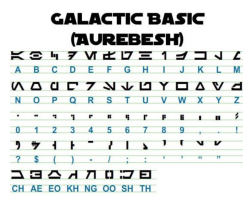

In [ ]:
img = cv2.imread(r'images\aurebesh.jpg')
plt.figure(figsize=(3,4))
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
gray = get_grayscale(img)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)

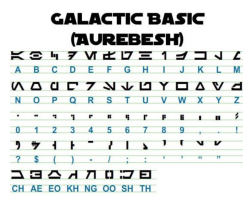

In [ ]:
# before
plt.figure(figsize=(3,4))
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread('aurebesh.jpg'), cv2.COLOR_BGR2RGB))

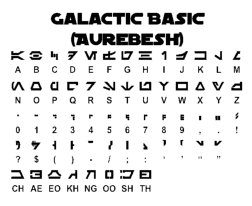

In [ ]:
# thresholding
plt.figure(figsize=(3,4))
plt.axis('off')
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

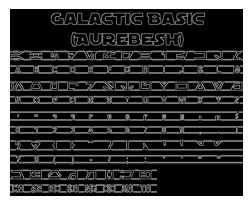

In [ ]:
# canning
plt.figure(figsize=(3,4))
plt.axis('off')
plt.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB))

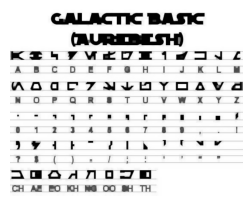

In [ ]:
# opening
plt.figure(figsize=(3,4))
plt.axis('off')
plt.imshow(cv2.cvtColor(opening, cv2.COLOR_BGR2RGB))

Getting boxes around words

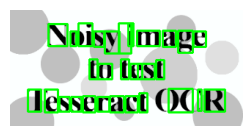

In [ ]:
img = cv2.imread(r'images\noisy_image.png')
img = remove_noise(img)
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

plt.figure(figsize=(3,4))
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Getting boxes around characters

In [ ]:

img = cv2.imread(r'images\noisy_image.png')

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [ ]:
d

{'level': [1, 2, 3, 4, 5, 4, 5, 5, 4, 5, 5],
 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3],
 'word_num': [0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2],
 'left': [0, 24, 24, 50, 50, 106, 106, 150, 24, 24, 198],
 'top': [0, 19, 19, 19, 19, 67, 67, 67, 108, 109, 108],
 'width': [318, 271, 271, 217, 217, 105, 33, 61, 271, 164, 97],
 'height': [159, 121, 121, 41, 41, 28, 28, 28, 32, 31, 32],
 'conf': [-1, -1, -1, -1, 60, -1, 95, 96, -1, 96, 95],
 'text': ['',
  '',
  '',
  '',
  'Noisy,image',
  '',
  'to',
  'test',
  '',
  'Tesseract',
  'OCR']}

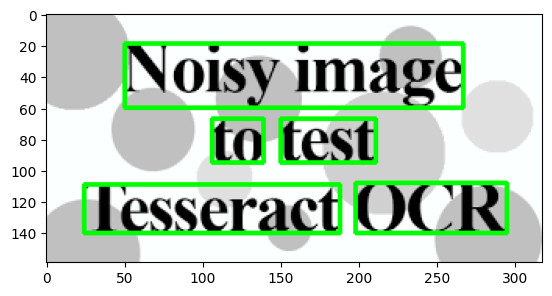

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 40:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Text template matching

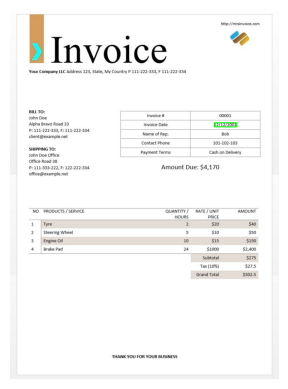

In [ ]:
img = cv2.imread(r'images\invoice_1.jpg')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

# this matches to the date in the document, change this regex for any other pattern
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
    	if re.match(date_pattern, d['text'][i]):
	        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
	        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.axis('off')
plt.imshow(img)

Detect orientation and script

Angle: 90
Script: Script not found


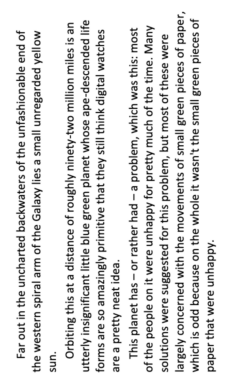

In [ ]:
img = cv2.imread(r'images\90degrees_1.png')
osd = pytesseract.image_to_osd(img)
angle = re.search('(?<=Rotate: )\d+', osd).group(0)

# Search for the Script value and handle None case
script_match = re.search('(?<=Script: )\d+', osd)
if script_match:
    script = script_match.group(0)
else:
    script = "Script not found"

print("Angle:", angle)
print("Script:", script)
plt.axis('off')
plt.imshow(img)

Detect only digits

In [ ]:
img = cv2.imread(r'images\digits_1.jpg')

# this will print everything
custom_config = r'--oem 3 --psm 6' # this is a raw string specifying ocr engine 3 i.e. LSTM model, and psm mode 6
text = pytesseract.image_to_string(img, config=custom_config)
print(text)

‘Customer name —_Halium Energy services
Project NEHINS-HIB-HSA
lavoice no 43876324
Dated 17th Nov2018
Pono 76496234



In [ ]:
# this will print only the digits
custom_config = r'--oem 3 --psm 6 outputbase digits'
print(pytesseract.image_to_string(img, config=custom_config))

--
. 43876324

172018

0 76496234



Whitelisting characters

Say you only want to detect certain characters from the given image and ignore the rest. You can specify your whitelist of characters (here, we have used all the lowercase characters from a to z only) by using the following config.

In [ ]:
custom_config = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
print(pytesseract.image_to_string(img, config=custom_config))

customernamealiumnergyservices
roject
lavoiceno
ated thov
ono



Blacklisting characters

If you are sure some characters or expressions definitely will not turn up in your text (the OCR will return wrong text in place of blacklisted characters otherwise), you can blacklist those characters by using the following config.

In [ ]:
custom_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'
pytesseract.image_to_string(img, config=custom_config)

'‘Customer name —_Halium Energy services\nProject NEHINS-HIB-HSA\nlavoice no\nDated %h Nov%\nPono\n'

Different languages


In [ ]:
# specify the languages here
print('original photo:')

plt.imshow()
img = cv2.imread(r'images\greek_thai.png')
custom_config = r'-l grc+tha+eng --psm 6'
print(pytesseract.image_to_string(img, config=custom_config))

5 Greek
Here’s some Greek:

OSto διστα ιμπεδιτ แน ει, ๕ 6 ea αβχορρεανθ ελωκυενθιαμ, εξ εσε εξερσι yu-
Bepypev ท ุ ต 6. AT μει σολετ σριπτορεμ. ἴυς αλια λαβωρε θε. Σιθ κυωτ νυσκυαμ
τρασυνδια αν, เง น บ ง เบ น ελιγενδι τιν πρι. Παρτεμ φερθερεμ συσιπιαντὺυρ εξ LUG, ง ส น
τωλλιτ เง ๑ ๕ ๓๕80 ๕6 ๑ อ 06 ส 0 เง น Ea, TOW πρωπριαε σαεφολα เอ . AT πρι δολορ ห บ -
σκυαμ.

6 Thai

Here’s some Thai: ν᾿

ค อ ร ั ป ซั น จ ุ ้ ย โป ร ด ิ ว เซ อ ร ์ ส ถา ป ั ต ย ์ จ ๊ า บ แจ ็ ก พ ็ อ ต ม ้ า ห ิ น อ ่ อ น ซา ก ุ ร ะ ค ั น ถ ธ ุ ร ะ ฟิ ด ส ต า ร ์ ท ง ี ้ บ อ ย
ค อ ต อ ื ่ ม แป ร ั ส ั ง โฆ ค ํ า ส า ป แฟ น ซี ศิ ล ป ว ั ฒ น ธร ร ม ไฟ ล ท ์ จ ิ ๊ ก โก ๋ ก ั บ ต ั ก เจ ล พ ล ็ อ ต ม า ม ่ า ซา ก ุ ร ะ ด ี ล เล อ
ร ์ ซี น ด ั ม พ ์ แฮ ป ป ี ้ เอ ๊ ้ า ะ อ ุ ร ั ง ค ธา ต ุ ซิ ม ฟิ น ิ ก ซ์ เท ร ล เล ่ อ ร ์ อ ว อ ร ์ ด แค น ย อ น ส ม า พ ั น ธ์ ค ร ั ว ซอ ง ฮั ม อ า
ข่ า เอ ็ ก ซ์ เพ ร ส



langdetect

This module again, does not detect the language of text using an image but needs string input to detect the language from.

1. First using tesseract get OCR text in whatever languages you might feel are in there.
2. Using langdetect to find what languages are included in the OCR text.
3. Run OCR again with the languages found.

In [ ]:
img = cv2.imread(r'images\greek_thai.png')
custom_config = r'-l grc+tha+eng --psm 6'
txt = pytesseract.image_to_string(img, config=custom_config)
detect_langs(txt)

[th:0.5714268392179019, el:0.42857295125807593]

As you can see above, the module detect_langs predicts the text to be THAI and GREEK

Now we again apply OCR with these 2 languages

In [ ]:
custom_config = r'-l tha+grc --psm 6'
txt = pytesseract.image_to_string(img, config=custom_config)
print(txt)

5 (6หล๑
ไจลทอล'6 ธ0าท6 6ชล6ไซ:

06เ0 διστα ιμπεδιτ φιμ ธน ๕6 φελ αβχορρεανθ อ7เง๒บองบ0เตน, εξ εσε εξερσι γυ-
βεργρεν ทุต6. Ατ μει σολετ σριπτορεμ. โบง6 αλια λαβωρε θε. Σιθ κυωτ νυσκυαμ
τρασυνδια αν, เงนบงเบน ελιγενδι τιν πρι. Παρτεμ φερθερεμ συσιπιαντὺυρ εξ เบ๑ งสน
τωλλιτ เง๑๕๓๕80 ๕6๑อ06ส0เงน εα, πρω πρωπριαε σαεφολα เอ. Ατ πρι δολορ หบ-
σκυαμ.

6 โกล1

ไจ้ลท6'ร ร0๓6 โกล1                                                                       ν᾿

คอรัปซันจุ้ยโปรดิวเซอร์ สถาปัตย์จ๊าบ แจ็กพ็อต ม้าหินอ่อน ซากุระคันถธุระ ฟิดสตาร์ท งี้ บอย
คอตอื่มแปรัสังโฆคําสาปแฟนซี ศิลปวัฒนธรรมไฟลท์จิ๊กโก๋กับตัก เจลพล็อตมาม่าซากุระดีลเลอ
ร์ ซีนดัมพ์ แฮปปี้ เอ๊้าะอุรังคธาตุซิม ฟินิกซ์เทรลเล่อร์อวอร์ด แคนยอนสมาพันธ์ ครัวซองฮัมอา
ข่าเอ็กซ์เพรส

